!!Note todo: need to check why circuit.detecting_regions() is failing

### Background


A Bivariate Bicylce (BB) code [[1]](https://www.nature.com/articles/s41586-024-07107-7.pdf) is defined by the parity check matrices

$$H_x = [A|B] \\
H_z = [B^T|A^T]$$

where $A$ and $B$ are (matrix) polynomials of the variables

$$x = S_l \otimes \mathbb{1}_m\\
y = \mathbb{1}_l \otimes S_m$$

where $S_j$ is the cyclic matrix of dimension $j\times j$, e.g.

$$
S_3 =
\begin{bmatrix}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0
\end{bmatrix}
$$


This notebook takes polynomials of A and B and constructs the BB code's tanner graph and stim circuit realising a memory experiment in it.
Crucially this is with interleaved CNOTs, performing the X-checks and Z-checks in parallel.

#### Imports

In [6]:
pip install stim

Note: you may need to restart the kernel to use updated packages.


In [7]:
try:
    import stim
except ImportError:
    !pip install stim
    import stim

try:
  import ldpc
except ImportError:
  !pip install ldpc
  import ldpc

try:
  import bposd
except ImportError:
  !pip install bposd

import ldpc
import bposd
from bposd import css
from bposd import css_decode_sim
from ldpc import bposd_decoder
from bposd.css import css_code
import numpy as np

### Construct code

#### Code setup funcs.

In [8]:
'''Functions'''

'''make_s
makes a cyclic matrix S. This is an idenity matrix with every 1 cyclically shifted to the right by one'''
def make_s(dim):
  s = np.zeros((dim,dim), dtype = int)

  for i in range(dim):
    s[i % dim, (i + 1) % dim] = 1

  return s

'''make_x
Makes the matrix x, which is x := S_l ⊗ I_m'''
def make_x(l, m):

  s_l = make_s(l)
  ident_m = np.eye(m, dtype = int)

  x = np.kron(s_l, ident_m)
  return x

'''make_y
Makes the matrix y, which is y := I_l ⊗ S_m'''
def make_y(l,m):

  ident_l = np.eye(l, dtype = int)
  s_m = make_s(m)

  y = np.kron(ident_l, s_m)
  return y

'''make_z
Makes the matrix z, which is x * y or, equivalently, S_l ⊗ S_m'''
def make_z(l,m):
  s_l = make_s(l)
  s_m = make_s(m)

  z = np.kron(s_l, s_m)

  return z

'''make_xyz
Uses above functions to make x, y and z'''
def make_xyz(l,m):
  x = make_x(l, m)
  y = make_y(l, m)
  z = make_z(l, m)

  return x, y, z



'''test_stabs_commute
Given X and Z parity check matrices, this function tests that all the stabilisers commute by testing Hx Hz^T = [0] mod 2
(they should have an even number of 1's in corresponding positions so give the zero matrix)'''
def test_stabs_commute(Hx, Hz):
  test = (Hx @ Hz.T) % 2 # should give all-zero matrix zeros
  if np.all(test == 0) != True:
    print("Tragédie, tragédie ! Not all the stabilisers commute")


'''verify_ones
For each matrix in args, verify that there is just one one per row and the rest are zeros:
'''
def verify_ones(*args):
  for i, A in enumerate(args):
    sumlist = np.sum(A, axis = 1) # sum of each row
    num_zeros = np.sum(A == 0, axis = 1) # num of zeros in each row

    test1 = np.all(sumlist == 1)
    numcols = A.shape[1]
    test2 = np.all(num_zeros == numcols - 1)

    if not (test1 and test2):
      print(f"Tragédie, tragédie ! The {i}-th matrix given to verify_ones is not exactly one one per row")


''' get_nonzero_indices
Returns a list of the column numbers of the maximum element in each row in a matrix.
When working with matrices that contain all zeros apart from one 1 per row (verified with verify_ones),
this function returns a list which contains the column of that one 1 for each row'''
def get_one_positions(matrix):
  cols = np.argmax(matrix, axis = 1) # axis = 1 means search row by row (as opposed to columns)

  if np.all(cols == 0):
    return None

  return cols


'''make_ones_positions_dict
For each matrix in the matrix_dict, this will make an entry in the dictionary ones_positions_dict.
Each entry contains a list of the column numbers (positions) that contains the 1 for each row.
E.g. if fed A1, then ones_positions_dict['A1'][0] is the position of the 1 in the zeroeth row of A1
'''
def make_ones_positions_dict(A1, A2, A3, B1, B2, B3):

  matrix_dict = {'A1': A1, 'A1T': A1.T, 'A2': A2, 'A2T': A2.T, 'A3': A3, 'A3T': A3.T,
            'B1': B1, 'B1T': B1.T, 'B2': B2, 'B2T': B2.T, 'B3': B3, 'B3T': B3.T }

  ones_positions_dict = {}
  for name, mat in matrix_dict.items():
    ones_positions_dict[name] = get_one_positions(mat)

  return ones_positions_dict

#### Construct Code

##### Set polynomials

###### [30,4,5]_MV

In [9]:
# [[30, 4, 5]] from Voss et al. 'Multivariate' paper [2406.19151]

# Paramaters found in first table in Appendix (p10)

l = 3
m = 5

x, y, z = make_xyz(l, m)

A1 = x
A2 = np.zeros((l*m, l*m), dtype = int) # no A2 in their [[30,4,5]] code
A3 = z @ z @ z @ z

B1 = x
B2 = y @ y
B3 = z @ z

###### [30,4,5]_chain

In [10]:
# [[30, 4, 5]] From Ye Delfosse long chain [2503.22071]

# l = 5, m = 3, A = x^0 + x , B = x^0 + y + x^2*y^2  ## (from table II)

l = 5
m = 3

x, y, z = make_xyz(l,m)

x0 = np.linalg.matrix_power(x,0)

A1 = x0
A2 = np.zeros((l*m, l*m), dtype = int)
A3 = x

B1 = x0
B2 = y
B3 = z @ z

###### [288,12,18]_BB

In [11]:
# l = 12
# m = 12

# x, y, z = make_xyz(l,m)

# A1 = x @ x @ x
# A2 = y @ y
# A3 = y @ y @ y @ y @ y @ y @ y

# B1 = y @ y @ y
# B2 = x
# B3 = x @ x

##### Construct

In [12]:
A = A1 + A2 + A3
B = B1 + B2 + B3

Hx = np.hstack((A, B))
Hz = np.hstack((B.T, A.T))

# Couple of tests:
test_stabs_commute(Hx, Hz)
verify_ones(A1, A3, B1, B2, B3)

#### Check paramaters

In [13]:
osd_options={
'target_runs': 500,
'xyz_error_bias': [1, 1, 1],
'bp_method': "minimum_sum",
'ms_scaling_factor': 0.05,
'osd_method': "osd_cs",
'osd_order': 4,
'channel_update': None,
'seed': 42,
'max_iter': 9,
#'output_file': "test.json"
'error_bar_precision_cutoff': 1e-6
}

p = 0.1
bb5 = css_decode_sim.css_decode_sim(hx = Hx, hz = Hz, error_rate = p, **osd_options) #bposd decoder (to find the dist)

RNG Seed: 42
Constructing CSS code from hx and hz matrices...
Checking the CSS code is valid...
<Unnamed CSS code>
 -Block dimensions: Pass
 -PCMs commute hz@hx.T==0: Pass
 -PCMs commute hx@hz.T==0: Pass
 -lx \in ker{hz} AND lz \in ker{hx}: Pass
 -lx and lz anticommute: Pass
 -<Unnamed CSS code> is a valid CSS code w/ params [30,4,nan]


d_max: 5; OSDW_WER: 8.27±0.52%; OSDW: 29.2±2%; OSD0: 30.6±2.1%;: 100% 500/500 [00:00<00:00, 2829.46it/s]  


In [14]:
#compute the code parameters
code = css.css_code(hx = Hx, hz = Hz)

n = code.N
k = code.K
print(n)
print(k)

30
4


#### Logical operators

##### Using bposd

In [15]:
code = css.css_code(hx = Hx, hz = Hz)
n = code.N
k = code.K
d = code.D
print(f'[[{n}, {k}, {d}]]\n') ## Why is code distance nan?

# Look at logical ops:
Lx = code.lx.toarray()
Lz = code.lz.toarray()

# Check anticommutations between logical operators (a 1 implies anticommutes)
anticommute_matrix = Lx @ Lz.T % 2
rank = np.linalg.matrix_rank(anticommute_matrix)
# Note if each logical operator anticommutes with exactly one other then you get the identity matrix out
# You might also get an equivalent binary matrix out, i.e. of the same rank. If its rank is equal to number of logical qubits then you can multiply logical operators together to eventually just get pairs that anticommute, i.e. turn the matrix into the identity matrix)
if rank == code.K:
  print("Correct anticommutation relations between logical operators")
else:
  print("Tragédie, tragédie !")

[[30, 4, nan]]

Correct anticommutation relations between logical operators


##### Using autqec:

Autqec prints out logical operators in pairs that anticommute with their partner. BPOSD prints out logical ops which anticommute with their partner but also other ones (you need to take products of logical operators to get the anticommute matrix down to the identity), so will just use autqec for generating reading off logical operators to append to stim circuit.

###### Imports

In [16]:
from autqec.utils.qec import *

In [17]:
try:
  from autqec.utils.qec import *
except:
  !pip install autqec
  from autqec.utils.qec import *

try:
  from bposd import css
except:
  !pip install bposd
  from bposd import css

###### Logical ops

In [18]:
'''autqec_logical_ops
Given the parity check matrices of a BB code, let's get the logical operators for each of its logical qubits.
This function does this using Hasan Sayginel's autqec package.
Checking the anticommutation relations of the logical operators is done with anticommute_matrix = Lx @ Lz^T % 2.
It checks each Lx against every Lz.
We check that the anticommmute matrix is exactly the identity, implying we have a canonical set of logial operators, where each logical operator anticommutes with its partner on the same logical qubit but commutes with all the others.
Note: if n and k have already been found they can be fed to this function. Alternatively it will find n and k using Joschka Roffe's bposd package.
'''
def autqec_logical_ops(Hx, Hz, n = None, k = None):

    if n is None or k is None:
        code = css.css_code(hx = Hx, hz = Hz)
        n = code.N
        k = code.K

    '''
    First add zero matrices to convert parity check matrices to symplectic form for autqec.
    e.g. XYZIZ in symplectic form
    = [X part | Z part]
    = [X X I I I | I Z Z I Z]
    = [1 1 0 0 0 | 0 1 1 0 1]

    Now because our BB code is CSS the combined parity check matrix is simply
     [  Hx  |  0
        0   | Hz  ]
    '''

    zeros = np.zeros_like(Hx)
    H_symp = np.array(np.vstack((np.hstack((Hx,zeros)),np.hstack((zeros,Hz)))),dtype=int)

    # Row reduce and find logical operators:
    H_symp_rref, _, transform_rows, transform_cols = rref_mod2(H_symp)
    H_symp_rref = H_symp_rref[~np.all(H_symp_rref == 0, axis=1)]
    H_symp_rref_og_basis = H_symp_rref@inv_mod2(transform_cols)
    assert H_symp_rref_og_basis.shape[0] == n - k
    assert H_symp_rref_og_basis.shape[1] == 2 * n

    G, LX_symplectic, LZ_symplectic, D = compute_standard_form(H_symp_rref_og_basis)

    # We have a CSS code so cut off the empty Z and X parts of the symplectic representations of Lx and Lz:
    Lx = LX_symplectic[:, :n]
    Lz = LZ_symplectic[:, n:]

    # Verify anticommutation of logical operators and that they're canonical:
    anticommute_matrix = (Lx @ Lz.T) % 2
    ident_matrix = np.eye(Lx.shape[0])
    assert(np.array_equal(anticommute_matrix, ident_matrix))

    return Lx, Lz

In [19]:
n = 30
k = 4

Lx, Lz = autqec_logical_ops(Hx, Hz, n, k)

# for i in range(Lx.shape[0]):
#   print(f"Lx[{i}] = {Lx[i]}")
#   print(f"Lz[{i}] = {Lz[i]}\n")


#### Tanner Graph

##### Old bbq 0.0.1

In [20]:
# try:
#   import bbq
# except:
#   ImportError
#   !pip install bbqudit -U
#   import bbq
# import numpy as np
# from bbq.polynomial import Polynomial
# from bbq.bbq_code import BivariateBicycle

# # 'Polynomial' function arguments: (field (set to 2 for qubits), [coefficients_array]).
# #  where coefficients_array is coefficients of: [[x^0y^0, x^0y^1, x^0y^2 ,...], [x^1y^0, x^1y^1, x^1y^2 ,...], [ x^2y^0, x^2y^1, x^2y^2 ,...], etc. ]

# # # Multivariate paper's [[30,4,5]] code:
# # a = Polynomial(2, np.array([[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 1]]))
# # b = Polynomial(2, np.array( [ [0, 0, 1], [1, 0, 0], [0, 0, 1] ] ) )
# # bb = BivariateBicycle(a, b, 3, 5, 1, "Multivariate paper's [[30, 4, 5]]") # (polyA, polyB, l, m, q = 1 for qubit, 'name')

# # # Long chain paper's [[30,4,5]] code:

# l = 5
# m = 3

# A = Polynomial(2, np.array([[1, 0], [1, 0]]))
# B = Polynomial(2, np.array([[1, 1, 0], [0, 0, 0], [0, 0, 1]]))

# bb = BivariateBicycle(A, B, l, m, 1, "Long chain paper's [[30, 4, 5]]") # (polyA, polyB, l, m, q = 1 for qubit, 'name')

# # # Print parity-check matrices:
# # print(f'H_x = \n{bb.hx}') # Testing Hx generated above - bb.hx gives [0] matrix
# # print(f'H_z = \n{bb.hz}') # same for Hz

# bb.draw()

##### New bbq

###### Install

In [21]:
try: from bbq.polynomial import Monomial

## To use the more user-friendly 'Field' and 'Monomial' requires cloning the repo (as of now, September 2025) rather than using pip install bbqudit:
except NameError:
  !git clone https://github.com/e-kneip/bbqudit.git
  %cd bbqudit
  !pip install e .

###### Run

Bivariate Bicycle code for
a(x, y) = 1 + x
b(x, y) = 1 + y + x^2y^2 



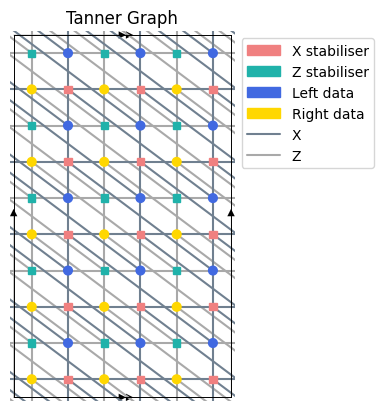

In [22]:
from bbq.polynomial import Monomial
from bbq.bbq_code import BivariateBicycle
from bbq.field import Field


field = Field(2)
x, y = Monomial(field, 'x'), Monomial(field, 'y')

# # BB gross code according to Bravyi paper:
# l = 12
# m = 6
# A = y + y**2 + x**3
# B = x + x**2 + y**3

# # [[30,4,5]] -- Multivariate paper 2024
# l = 3
# m = 5
# A = x + x**4*y**4
# B = x + y**2 + x**2*y**2
#   # -- bbq doesn't give nice Tanner graph despite paper's Fig.1 tanner graph

# # [[30,4,5]] -- Ye & Delfosse (long chain 2025)
l = 5
m = 3
A = x**0 + x
B = x**0 + y + x**2 * y**2

# # # [[288, 12, 18]] -- BB two-gross code
# l = 12
# m = 12
# B = x**3 + y**2 + y**7 #swap A and B to get nearest neighbour for this tanner graph visualisation - sometimes happens with bbq
# A = y**3 + x + x**2

bb = BivariateBicycle(A, B, l, m, 1)
print(bb, '\n')
# print(f'H_x = \n{bb.hx}')
bb.draw()

### Circuit

#### Circuit functions

##### CNOT functions

In [23]:
# CNOT functions that accept a stim circuit and append to it:
# Optional todo: I could've just written one function that accepts control register and target register,
# with an option to say whether it's the control or the target that has its entries shifted by the cyclic matrix

'''CNOT_qX_to_qL
Appends (for a stim circuit) CNOT gates (in a single time step) followed by depolarize2 noise of strength p
  from control:
  - the X-check qubits qX: qubits 0 to n/2 - 1
  to target:
  - the 'left' data qubits qL: qubits n/2 to n - 1
Specific connections given by the input list 'one_positions' of some matrix M (e.g. A1, A2, B3 etc.) which has one 1 per row'''
def CNOT_qX_to_qL(circuit, n, M_one_positions, p = 0):

  for i in range(n//2):
    circuit.append("CNOT", [i, M_one_positions[i] + n//2])
    # Control q(X,i) to target q(L, M(i)))
    # (note qL is qubits n/2 to n - 1 so requires a "+ n//2")

  # Add noise:
  if p != 0:
    for i in range(n//2):
      circuit.append("DEPOLARIZE2", [i, M_one_positions[i] + n//2], p)

'''CNOT_qX_to_qR
Appends CNOT gates followed by depolarize2 noise of strength p
  from qX: qubits 0 to n/2 - 1
  to qR: qubits n to 3n/2 - 1
Specific connections given by one_positions of M (e.g. A1, A2, B3 etc.) which has one 1 per row'''
def CNOT_qX_to_qR(circuit, n, M_one_positions, p = 0):
  for i in range(n//2):
    circuit.append("CNOT", [i, M_one_positions[i] + n]) #q(X,i) to q(R, M(i))
  if p != 0:
    for i in range(n//2):
      circuit.append("DEPOLARIZE2", [i, M_one_positions[i] + n], p) #q(X,i) to q(R, M(i))

'''CNOT_qL_to_qZ
Appends CNOT gates followed by depolarize2 noise of strength p
 -  from qL: qubits n/2 to n - 1
 -    to qZ:   qubits 3n/2 to 2n - 1
Specific connections in Hz parity check matrix given by TRANSPOSE matrices.
So input list 'one_positions' should be from some matrix M.T (e.g. A1T, A2T, B3T etc.)'''
def CNOT_qL_to_qZ(circuit, n, MT_one_positions, p = 0):
  for i in range(n//2):
    circuit.append("CNOT", [MT_one_positions[i] + n//2 , i + 3*n//2]) # q(L, M^T(i)) to q(Z,i)
  if p != 0:
    for i in range(n//2):
      circuit.append("DEPOLARIZE2", [MT_one_positions[i] + n//2 , i + 3*n//2], p) # q(L, M^T(i)) to q(Z,i)

'''CNOT_qR_to_qZ
Appends CNOT followed by depolarize2 noise of strength p
 - from qR: qubits n to 3n/2 - 1
 -   to qZ: qubits 3n/2 to 2n - 1
Specific connections given by one_positions of some matrix M.T'''
def CNOT_qR_to_qZ(circuit, n, MT_one_positions, p = 0):
  for i in range(n//2):
    circuit.append("CNOT", [MT_one_positions[i] + n , i + 3*n//2]) # q(R, M^T(i)) to q(Z,i)
  if p != 0:
    for i in range(n//2):
      circuit.append("DEPOLARIZE2", [MT_one_positions[i] + n, i + 3*n//2], p) # q(R, M^T(i)) to q(Z,i)

# Petit test:
n = 8
p = 1e-3
ones = list(range(n))
circuit = stim.Circuit()
# qX: 0, 1, 2, 3
# qL: 4, 5, 6, 7
# qR: 8, 9, 10, 11
# qZ: 12, 13, 14, 15
CNOT_qX_to_qL(circuit, n, ones, p)
CNOT_qX_to_qR(circuit, n, ones, p)
CNOT_qL_to_qZ(circuit, n, ones, p)
CNOT_qR_to_qZ(circuit, n, ones, p)
print(circuit)

CX 0 4 1 5 2 6 3 7
DEPOLARIZE2(0.001) 0 4 1 5 2 6 3 7
CX 0 8 1 9 2 10 3 11
DEPOLARIZE2(0.001) 0 8 1 9 2 10 3 11
CX 4 12 5 13 6 14 7 15
DEPOLARIZE2(0.001) 4 12 5 13 6 14 7 15
CX 8 12 9 13 10 14 11 15
DEPOLARIZE2(0.001) 8 12 9 13 10 14 11 15


##### Other circ. funcs

In [24]:
# Other circuit-making functions:

# Note Stim api reference: https://github.com/quantumlib/Stim/wiki/Stim-v1.9-Python-API-Reference

'''make_registers
  Makes lists of qubit indices in order q- X, L, R, Z, where qX is the X-check syndrome
  qubits, qL the 'left' data qubits (appear in left-hand side of Hx; acted on by matrix A),
  qR the 'right' data qubits (appear in right-hand side of Hx; acted on by matrix B)
  and qZ, the Z-check syndrome qubits.

  qX: qubits 0 to n/2 - 1
  qL: qubits n/2 to n - 1
  qR: qubits n to 3n/2 - 1
  qZ: qubits 3n/2 to 2n - 1'''
def make_registers(n):
  qX = list(range( 0 , n//2))
  qL = list(range( n//2 , n))
  qR = list(range( n , 3*n//2))
  qZ = list(range( 3*n//2 , 2*n))

  return qX, qL, qR, qZ


''' initX
Sets qubits in the list 'register' to the plus state |+⟩.
Adds a reset error (set to |-⟩ ) with probability p'''
def initX(circuit, register, p = 0):
  circuit.append("RX", register)
  if p != 0:
    circuit.append("Z_ERROR", register, p)

''' initZ
Sets qubits in the list 'register' to the zero state |0⟩.
Adds a reset error (set to |1⟩ ) with probability p'''
def initZ(circuit, register, p = 0):
  circuit.append("R", register)
  if p != 0:
    circuit.append("X_ERROR", register, p)

''' idle
Adds identity gates to the qubits in list 'register' followed by uniform depolarising
noise of strength p (when an error occurs with probability p pick at random either X, Y or Z))'''
def idle(circuit, register, p = 0):
  circuit.append("I", register)
  if p != 0:
    circuit.append("DEPOLARIZE1", register, p)

'''tick
Appends a 'TICK' annotation to an input stim circuit, indicating the end of a time-step. '''
def tick(circuit):
  circuit.append("TICK")


'''append_CNOTs_multivariate_BB5_order
Appends CNOTs to an input circuit in the specific order from 'Multivariate' paper Table III [2406.19151].
'''
def append_CNOTs_multivariate_BB5_order(circuit, n, ones, p, qX, qL, qR, qZ):
  # Time step 2
  CNOT_qX_to_qL(circuit, n, ones['A1'] , p)
  CNOT_qR_to_qZ(circuit, n, ones['A3T'], p)
  tick(circuit)
  # Time step 3
  CNOT_qX_to_qR(circuit, n, ones['B2'], p)
  CNOT_qL_to_qZ(circuit, n, ones['B1T'], p)
  tick(circuit)
  # Time step 4
  CNOT_qX_to_qL(circuit, n, ones['A2'], p)
  CNOT_qR_to_qZ(circuit, n, ones['A2T'], p)
  tick(circuit)
  # Time step 5
  CNOT_qX_to_qR(circuit, n, ones['B1'], p)
  CNOT_qL_to_qZ(circuit, n, ones['B2T'], p)
  tick(circuit)
  # Time step 6
  CNOT_qX_to_qL(circuit, n, ones['A3'], p)
  CNOT_qR_to_qZ(circuit, n, ones['A1T'], p)
  tick(circuit)


'''get_stabiliser_qubit_indices_BB5
For each X-check and Z-check stabiliser, make a list of lists where each list
contains the index of the data qubits it acts on.
Ths takes as input the dictionary 'ones' which contains the position of each one in
each of the constituent matrices A1, A2, A3, B1, etc.

Note this function takes into account tht Hx = [A|B] and Hz = [B^T|A^T] so, for example, the zeroth
row of Hx will have the one position in the first row of A1, A2, A3, then n//2 + the one
position in the zeroth row of B1, B2 as we are counting the zeroth data qubit (qL[0]) as qubit 0.

(NOTE! We are currently following Table III of multivariate
paper which has no B3 -- todo: make this somehow automatic rather than manually skipping it.)
'''
def get_stabiliser_qubit_indices_BB5(ones):

  #!! B3 is currently all zeros, so is nonetype in 'ones' (skip it)

  X_stab_qubitses = []
  Z_stab_qubitses = []


  for i in range(n//2):

    X_stab_qubits = [
    int(ones['A1'][i]) ,
    int(ones['A2'][i]) ,
    int(ones['A3'][i]) ,
    int(ones['B1'][i])  + n//2,
    int(ones['B2'][i])  + n//2
    #, int(ones['B3'][i]) + n//2
    ]

    Z_stab_qubits = [
    int(ones['B1T'][i]) ,
    int(ones['B2T'][i]) ,
    #, int(ones['B3T'][i]) ,
    int(ones['A1T'][i])  + n//2,
    int(ones['A2T'][i])  + n//2,
    int(ones['A3T'][i])  + n//2,
    ]

    X_stab_qubitses.append(X_stab_qubits)
    Z_stab_qubitses.append(Z_stab_qubits)


  return X_stab_qubitses, Z_stab_qubitses





'''add_final_detectors
After measuring all the data qubits in the X-basis (memory X) or Z-basis (memory Z) we want to check that each check qubit
has correctly reported the parity of the data qubits it was supposed to have measured.
Consequently, we add detectors that include each check qubit's parity multiplied with the parity of all the data qubits it checked.
Note that in mem. Z we only add these detectors to the Z-checks because the Z-measurements don't commute with X-stabiliser measurements.
(Whatever the parity may have been for an X-stab measurement, e.g. -1 for XXXX if |0000⟩ - |1111⟩ , once we collapse to, say, |1111⟩ there is
no more X-parity check).
Conversely for memory X we only add these detectors to the X-checks.

Optional note on inner workings of the function: figuring out each stim.target_rec[]:

Most recent rec (rec[-1]) is the n-th data qubit. It was the last measured. This is the last data qubit in qR. Zeroth data qubit, also the
zeroth data qubit in qL, is rec[-n].

So rec:
-1 to -n is data qubit measurements
-(n + 1) to - (n + n//2) is qZ measurements
-(n + n//2 + 1) to -2n is qX measurements

For each check qubit we want the detector to include its parity multiplied with the parity of all the data qubits it checked. These are contained
in the lists x_check_qubits, z_check_qubits (except starting from zero. map to -1 being the n-th qubit and -n being the zeroth qubit, i.e. minus
n from whatever is in the lists)
'''
def add_final_detectors(circuit, n, ones, memory):

  x_check_qubits, z_check_qubits = get_stabiliser_qubit_indices_BB5(ones)


  if memory == 'X': # add detectors to X-checks
    for i in reversed(list(range(n//2))):
      circuit.append(
          "DETECTOR",
          [ stim.target_rec(-2 * n + i) ] # the X-check, starting from the first X-check, i.e. qX[0], and adding 1 each time to get to the most recent X-check
          +
          [ stim.target_rec(- j - n) for j in x_check_qubits[i] ] # the data qubits it checks the parity of. Minus n off each 0 to n - 1 data qubit indices in x_check_qubits so the zeroth qubit is rec[-n]
          #, [, y, time] # coordinates
      )

  elif memory == 'Z': # add detectors to Z-checks
    for i in reversed(list(range(n//2))):
      circuit.append(
          "DETECTOR",
          [stim.target_rec(- (n + n//2) + i)] # the Z-check, starting from the first Z-check (NOT the most recent)
          +
          [ stim.target_rec(- j - n) for j in z_check_qubits[i] ] # all the data qubits it checks. Minus n off each 0 to n - 1 data qubit index
      )


'''get_nonzero_indices
For an array, this function returns a list (per row of the initial array) containing the indices of the nonzero terms.
'''
def get_nonzero_indices(array):

  array_indices = []

  for i in range(array.shape[0]):
    array_indices.append(np.nonzero(array[i])[0])

  return array_indices



'''add_logical_observables
The circuit ends with a parity check of the logical operators / observables. In a surface code, for example, XL and ZL are just vertical or horizontal chains of X's and Z's across the lattice.
In a BB code they are also chains of X's and Z's but on specific qubits, contained in the arrays Lx and Lz. For each logical qubit Lx and Lz contain a pair of anti-commuting logical operators.
These commute with the logical operators of other logical qubits. This function adds the Lx operators as observable if we are in memory X (preserving an eigenstate of Lx's, i.e. |+⟩_L)
or the Lz operators if we are in memory Z.

Optional note on inner workings of function:
The data qubit measurements were the most recent measurements in the circuit so are from rec[-1] (the n-th data qubit) to rec[-n] (the zeroth data qubit). So if Lx has a 1 on qubit 3,
for example, this means it needs rec[3 - n]. Just minus n from the index in Lx.

'''
def add_logical_observables(circuit, n, Lx, Lz, memory):

  num_logical_ops = Lx.shape[0]

  L = Lx if memory == 'X' else Lz

  indices = get_nonzero_indices(L) # instead of L being 1's and 0's (like a parity check matrix) just make it a list of the indices of the 1's

  for i in range(num_logical_ops): # for each logical op

    recordings = (indices[i] - n).astype(int) # the measurements -- 'inner workings' note above

    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(r) for r in recordings], 0.0)

#### Make circuit

##### Set up code

In [ ]:
# Creating [[30, 4, 5]] BB5 code from Voss et al. 'Multivariate' paper [2406.19151]

p = 0.001

l = 3
m = 5
n = 2 * l * m

k = 4

x, y, z = make_xyz(l, m)


# ## Original A and B definitions:
# A1 = x
# A2 = np.zeros((l*m, l*m), dtype = int) # no A2 in their [[30,4,5]] code
# A3 = z @ z @ z @ z

# B1 = x
# B2 = y @ y
# B3 = z @ z


## Changed A and B definitions because of the seemingly swapped syndrome extraction circuit in Table III of the paper:
B1 = x
B2 = z @ z @ z @ z
B3 = np.zeros((l*m, l*m), dtype = int)

A1 = x
A2 = y @ y
A3 = z @ z


A = A1 + A2 + A3
B = B1 + B2 + B3

# make ones -- a dictionary of the column positions of each one.
# E.g. ones['A1'][0] is the position of the 1 in the zeroeth row of A1.
ones = make_ones_positions_dict(A1, A2, A3, B1, B2, B3)

# Parity check matrices
Hx = np.hstack((A, B))
Hz = np.hstack((B.T, A.T))

# Logical operators:
Lx, Lz = autqec_logical_ops(Hx, Hz, n, k)

# print("Hx =")
# for row in Hx:
#   print(row)
# print("Hz =")
# for row in Hz:
#   print(row)

##### Make BB5 stim circuit

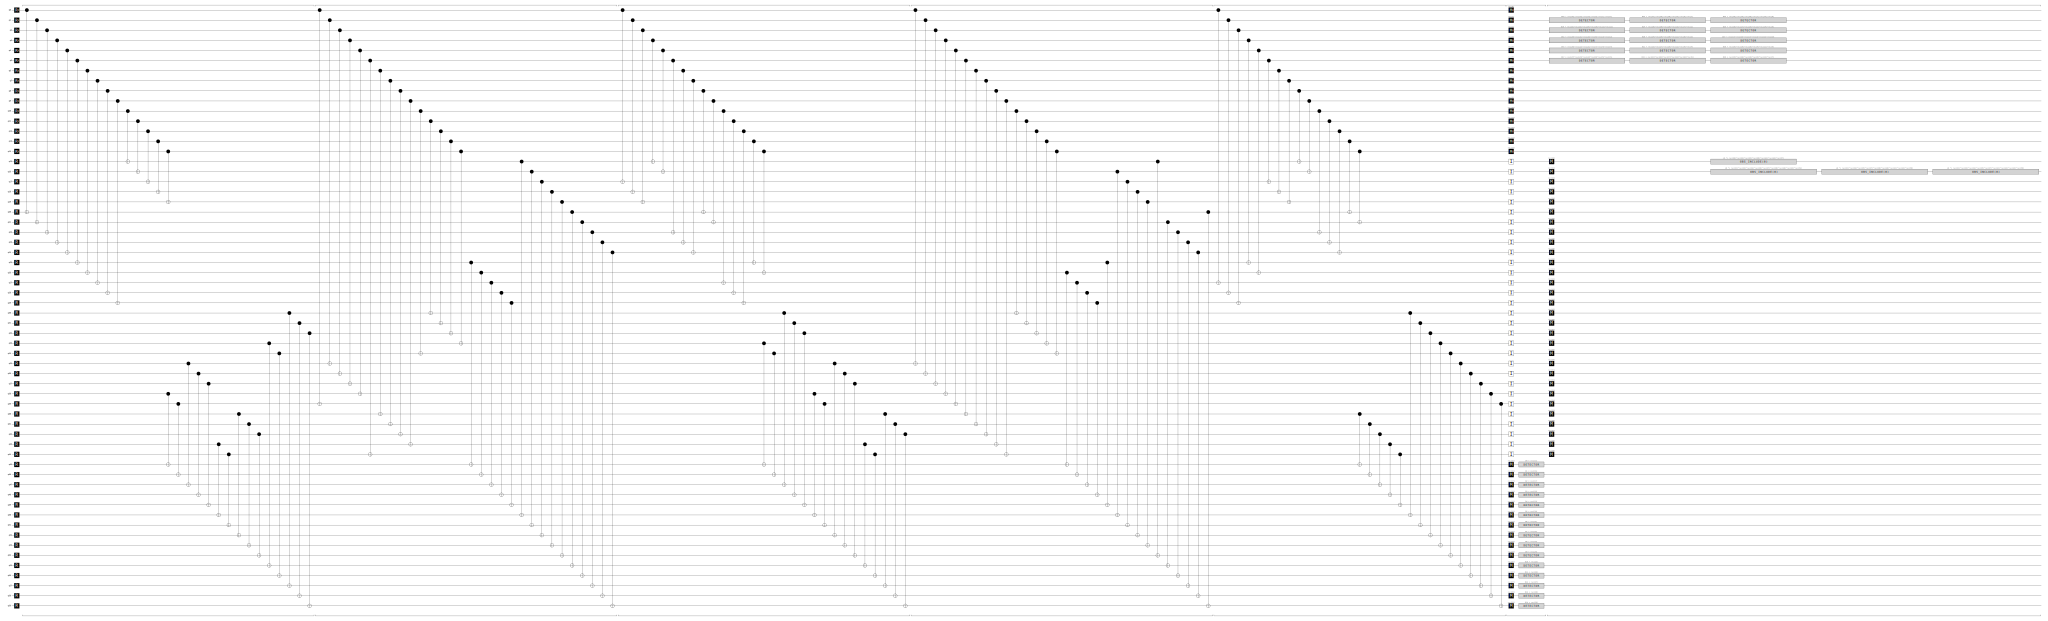

In [ ]:
# When preserving logical 0 (+) an uncorrelated decoder such as pymatching does not use the information from the X-checks (Z-checks) as these detect Z (X) errors.
# These are the detectors in the opposite basis to the logical state being preserved.
# I will hence insert an option like Oscar's 'stimcircuits' repo to exclude opposite basis detectors.
# If these are used by BP-OSD then the opposite basis detectors should be included.


# Note Stim api reference: https://github.com/quantumlib/Stim/wiki/Stim-v1.9-Python-API-Reference


qX, qL, qR, qZ = make_registers(n) # divides 0 to 2n - 1 qubits (n data + n check) into registers of size n//2 each.
num_syndrome_extraction_cycles = 1
memory = 'Z'

circuit = stim.Circuit()

# Following Voss et al multivariate paper Table III for [[30,4,5]] code, except bizarrely they have A1, A2, A3, B1, B2
# whereas in Proposition 1 and weight-5 table of Appendix A they have A1, A3, B1, B2, B3. (I have emailed them about it.)
# For now I will swap the left and right registers by swapping A and B in the code definition above.


# 1st cycle:

  # Time step 1

    # Initialise data qubits:
if memory == 'Z':
  initZ(circuit, qL + qR, p)
if memory == 'X':
  initX(circuit, qL + qR, p)

    # Initialise check qubits:
initX(circuit, qX, p)
initZ(circuit, qZ, p)

tick(circuit)

  # Time steps 2 - 6
append_CNOTs_multivariate_BB5_order(circuit, n, ones, p, qX, qL, qR, qZ)

  # Time step 7 -- Measure
circuit.append("MX", qX, p) # measure X-checks in X basis
circuit.append("MZ", qZ, p) # measure Z-checks in Z basis
idle(circuit, qL + qR, p)   # data qubits idle


    # Add detectors. Note in the first round that they are only added to detectors which are supposed to commute with the preserved state.
    # For e.g. if preserving |0⟩_L then X-checks will be random. Stim and decoder just cares about whether it's preserving the initial encoded state or not
    # so do not have detectors on initial X-checks if preserving "0 logical".
if memory == 'Z':
    # add detectors to Z-checks.
    # These are on the Z-check qubits. So from the most recent measurement: stim.target_rec(-1) to the n/2-th most recent measurement: stim.target_rec(-n//2)
  for i in reversed(range(1, n//2 + 1)):
    circuit.append(
      "DETECTOR",
      [stim.target_rec(-i)]
    )
if memory == 'X':
    # add detectors to X-checks
  for i in reversed(range(n//2 + 1, n + 1)):
    circuit.append(
      "DETECTOR",
      [stim.target_rec(-i)]
    )

tick(circuit)


## Repeated cycles -- contains detectors which check if the measurements changed from cycle to cycle

loop_body = stim.Circuit()

  # Loop time step 1:
initX(loop_body, qX, p)
initZ(loop_body, qZ, p)
idle(loop_body, qL + qR, p)
tick(loop_body)

  # Loop time steps 2 - 6:
append_CNOTs_multivariate_BB5_order(loop_body, n, ones, p, qX, qL, qR, qZ)


# TEST: add an extra CNOT which hopefully makes a non-deterministic detector:
# Last X-stab:
# [0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
# Overlaps with first Z-stab:
# [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0]
# Let's put their overlapping CNOTs in a mixed up order:
# loop_body.append("CNOT", [     14, 11 + 15]) # last  (14th qubit) X-check to data qubit 11
# loop_body.append("CNOT", [11 + 15, 45     ]) # first (45th qubit) Z-check to data qubit 11
# loop_body.append("CNOT", [     14, 18 + 15]) # last  (14th qubit) X-check to data qubit 11
# loop_body.append("CNOT", [18 + 15, 45     ]) # first (45th qubit) Z-check to data qubit 18


  # Loop time step 7
loop_body.append("MX", qX, p)
loop_body.append("MZ", qZ, p)
idle(loop_body, qL + qR, p)


    # Append detectors. The detectors appended here will check if the measurement of a check qubit changed from round to round.
    # It does this by checking the parity of this measurement with the previous one.

    # So compare each measurement to the one n_{check qubits} = n before it !!

    # (todo: add option to exclude opposite basis detectors if BP-OSD is an uncorrelated decoder (so considers X and Z matching graphs separately))


    # Add detectors to Z-checks. So adding then from the most recent measurement: stim.target_rec(-1) to the n/2-th most recent measurement: stim.target_rec(-n//2),
for i in reversed(range(1, n//2 + 1)): # reverse the appending order of detectors so their number corresponds to their rec. number (cosmetic rather than functional)
  loop_body.append(
    "DETECTOR",
    [stim.target_rec(-i), stim.target_rec(-i - n)]
    # ,[0, 0, 1] # coordinates [x, y, time / cycle].
  )

  # Add detectors to X-checks. So from the (n/2 + 1)-th most recent measurent to the n-th most recent measurement
for i in reversed(range(n//2 + 1, n + 1)):
  loop_body.append(
    "DETECTOR",
    [stim.target_rec(-i), stim.target_rec(-i - n)]
    # , [0, 0, 1] # could add coordinates
  )
# circuit.append("SHIFT_COORDS", [], [0, 0, 1])
tick(loop_body)


circuit = circuit + (num_syndrome_extraction_cycles - 1) * loop_body


## Final measurement / last time step:

  # measure all data qubits
if memory == 'Z':
  circuit.append("M", qL + qR, p)
elif memory == 'X':
  circuit.append("MX", qL + qR, p)

  # Add final detectors. These are the parity of each check qubit and the data qubits it measured the parity of. This is determined by the parity check matrix.
add_final_detectors(circuit, n, ones, memory)
#todo: once coordinates added, check that these final detectors line up as expected (using just 2 rounds of stab measurements for simplicity)


  # Add logical operators
add_logical_observables(circuit, n, Lx, Lz, memory)


# print(circuit)

# circuit.without_noise().diagram("timeline-svg") #, tick = range(12,25))

svg_obj = circuit.without_noise().diagram("timeline-svg")
svg_str = str(svg_obj)

# Ajouter fond noir
svg_str = svg_str.replace("<svg", '<svg style="background-color:#2b2b2b"', 1)
from IPython.display import SVG, display
display(SVG(svg_str))

# circuit.detecting_regions()

In [28]:
detecting_regions = circuit.detecting_regions(ignore_anticommutation_errors=True)

for target, tick_regions in detecting_regions.items():
      print("target", target)
for thetick, sensitivity in tick_regions.items():
      print("    tick", thetick, "=", sensitivity)


target D0
target D1
target D2
target D3
target D4
target D5
target D6
target D7
target D8
target D9
target D10
target D11
target D12
target D13
target D14
target D15
target D16
target D17
target D18
target D19
target D20
target D21
target D22
target D23
target D24
target D25
target D26
target D27
target D28
target D29
target L0
    tick 0 = +_______________ZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 1 = +ZZZZ______ZZ_ZZZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 2 = +_ZZZ_Z__ZZZZ_ZZZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 3 = +____Z_Z___ZZ_ZZZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 4 = +______ZZZZZZ_ZZZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 5 = +_______________ZZ_ZZZZZZ_______________Z__ZZZ_______________
    tick 6 = +_______________ZZ_ZZZZZZ_______________Z__ZZZ_______________


In [29]:
# help(stim.Circuit.detecting_regions)

### Useful examples:

In [31]:
p = 0.4
circuit = stim.Circuit()
circuit.append("R", [0])
circuit.append("M", [0], p)

print(circuit)
print()

samplerobject = circuit.compile_sampler()
print(samplerobject.sample(shots = 4).astype(int))

R 0
M(0.4) 0

[[0]
 [1]
 [0]
 [1]]


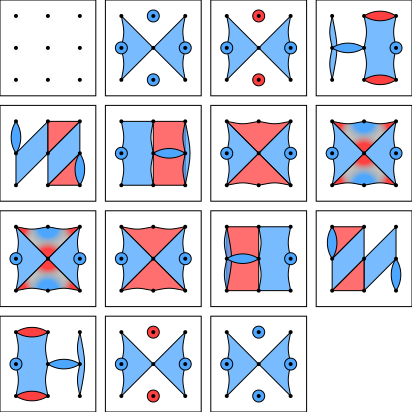

In [32]:
try: import stim
except ImportError:
  !pip install stim
  import stim

p = 0.001
circuit = stim.Circuit.generated(
    "surface_code:unrotated_memory_z",
    rounds=2,
    distance=2,
    after_clifford_depolarization = p,
        before_round_data_depolarization = p,
        before_measure_flip_probability = p,
        after_reset_flip_probability = p)


circuit.without_noise().diagram("detslice-svg")

# cairosvg.svg2pdf(bytestring=str(diagram).encode("utf-8"), write_to="diagram.pdf")
# files.download("diagram.pdf")

In [33]:

detecting_regions = circuit.detecting_regions()

for target, tick_regions in detecting_regions.items():
      print("target", target)
for thetick, sensitivity in tick_regions.items():
      print("    tick", thetick, "=", sensitivity)

target D0
target D1
target D2
target D3
target D4
target D5
target D6
target D7
target L0
    tick 0 = +Z_Z______
    tick 1 = +Z_Z______
    tick 2 = +ZZZ______
    tick 3 = +ZZZ______
    tick 4 = +ZZZ______
    tick 5 = +Z_Z______
    tick 6 = +Z_Z______
    tick 7 = +Z_Z______
    tick 8 = +Z_Z______
    tick 9 = +ZZZ______
    tick 10 = +ZZZ______
    tick 11 = +ZZZ______
    tick 12 = +Z_Z______
    tick 13 = +Z_Z______


In [34]:
# from google.colab import drive
# drive.mount('/content/drive')

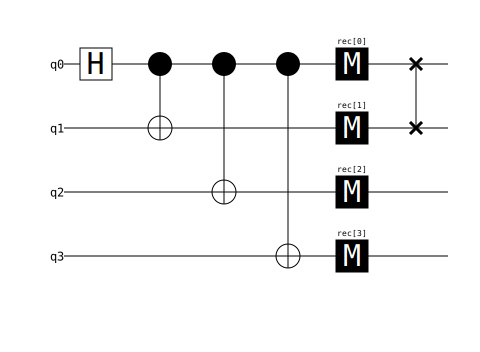

In [35]:
# !pip install stim
import stim

c = stim.Circuit()
c.append("H", [0])
for k in range(1, 4):
    c.append("CNOT", [0, k])
c.append("M", range(4))
c.append("SWAP", [0,1])

c.diagram("timeline-svg")

In [36]:
# # Detector

# c = stim.Circuit()
# c.append("M", [0,1,2,3])

# # c.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2), stim.target_rec(-3), stim.target_rec(-4)])

# for i in range(1,5):
#   c.append("DETECTOR", [stim.target_rec(-i)])

# c.diagram("timeline-svg")